In [1]:
# Imports
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window

In [2]:
# Create Spark session
spark = (
    SparkSession.builder.appName("Merchant Ranking Model")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "12g")
    .config("spark.driver.maxResultSize", "16G")
    .config("spark.executor.memory", "16G")
    .config("spark.sql.files.maxPartitionBytes", "64MB")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.network.timeout", "600s")
    .getOrCreate()
)


24/10/06 03:11:48 WARN Utils: Your hostname, codespaces-a59cd2 resolves to a loopback address: 127.0.0.1; using 10.0.0.16 instead (on interface eth0)
24/10/06 03:11:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/06 03:11:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Load data
future_revenue = spark.read.parquet('../data/curated/predicted_monthly_revenue.parquet')
transactions = spark.read.parquet('../data/curated/all_details/')
merchant_segment = spark.read.parquet("../data/curated/merchant_segment.parquet")
merchant_data = spark.read.parquet("../data/curated/part_1/*")

# Define the merchant segments of interest
segments = [
    "Entertainment & Media",
    "Office & Home Supplies",
    "Miscellaneous",
    "Beauty",
    "Technology"
]

In [4]:
# getting rid of records with null values
merchant_data = merchant_data.na.drop()
merchant_data.count()

4026

In [5]:
# Calculate the monthly revenue for each merchant
merchant_monthly = transactions.groupBy(F.date_format(F.col('order_datetime'), 'yyyy-MM'), 'merchant_abn').agg(F.sum('dollar_value'))
merchant_monthly = merchant_monthly.withColumn('month', F.month(F.col('date_format(order_datetime, yyyy-MM)')))

# Calculate the month since first transaction for each merchant
merchant_monthly = merchant_monthly.withColumn(
    'first_transaction', F.min('date_format(order_datetime, yyyy-MM)').over(Window.partitionBy('merchant_abn'))
)
merchant_monthly = merchant_monthly.withColumn(
    'month_since_first_transaction', F.months_between(F.col('date_format(order_datetime, yyyy-MM)'), F.col('first_transaction'))
)

# Get max month since the first transaction for each merchant
max_month = merchant_monthly.groupBy('merchant_abn').agg(F.max('month_since_first_transaction').alias('max_month'))

In [6]:
# Filter merchants with at least 12 months of data
merchant_monthly = merchant_monthly.join(max_month, 'merchant_abn')
merchant_monthly = merchant_monthly.filter(F.col('month_since_first_transaction') >= 12)

# Filter out the last 12 months of transactions for each merchant
merchant_monthly = merchant_monthly.filter(F.col('month_since_first_transaction') >= F.col('max_month') - 12)

# Sum the yearly revenue for each merchant
merchant_yearly = merchant_monthly.groupBy('merchant_abn').agg(F.sum('sum(dollar_value)').alias('yearly_revenue'))

# Sum predicted future monthly revenue for each merchant
summed_future_revenue = future_revenue.groupBy('merchant_abn').agg(F.sum('prediction').alias('predicted_yearly_revenue'))

# Join actual and predicted revenue
revenue = merchant_yearly.join(summed_future_revenue, 'merchant_abn')
revenue = revenue.withColumn('growth_rate', (F.col('predicted_yearly_revenue') - F.col('yearly_revenue')) / F.col('yearly_revenue'))

In [7]:
new_revenue = merchant_data.join(revenue, on='merchant_abn', how = 'left')
# Calculate growth in dollars
new_revenue = new_revenue.withColumn('growth_in_dollars', (F.col('predicted_yearly_revenue') - F.col('yearly_revenue'))*F.col('take_rate')/100)

In [8]:
new_revenue.sort('merchant_abn').show()

+------------+--------------------+--------------------+-------------+---------+------------------+-------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|merchant_abn|                name|               goods|revenue_level|take_rate| sum(dollar_value)|count(dollar_value)|         log_ratio|  unscaled_earning|    yearly_revenue|predicted_yearly_revenue|       growth_rate| growth_in_dollars|
+------------+--------------------+--------------------+-------------+---------+------------------+-------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
| 10023283211|       Felis Limited|furniture, home f...|            e|     0.18| 703277.7114509277|               3261| 5.373717954622449|1265.8998806116697|332183.53977708105|       584886.7452965686|0.7607336765965873|454.86576993507754|
| 10142254217|Arcu Ac Orci Corp...|cable

In [9]:
# Get merchant abn for each order id
order_abn = transactions.select('order_id', 'merchant_abn', 'order_datetime').distinct()

In [10]:
# Load customer fraud and merchant fraud data
consumer_fraud = spark.read.parquet('../data/curated/predicted_consumer_fraud/*')
consumer_fraud = consumer_fraud.join(order_abn, on='order_id', how='left')
agg_consumer_fraud = consumer_fraud.groupBy('merchant_abn').agg(F.avg('consumer_fraud').alias('consumer_fraud_prediction'))

# Load merchant fraud data
merchant_fraud = spark.read.parquet('../data/curated/predicted_merchant_fraud/*')
merchant_fraud = merchant_fraud.join(order_abn, on='order_id', how='left')

# Load customer retention data
customer_retention = spark.read.parquet('../data/curated/customer_retention/*')

In [11]:
merchant_fraud.show()

24/10/06 03:12:06 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+--------------------+------------------+------------+--------------+
|            order_id|    merchant_fraud|merchant_abn|order_datetime|
+--------------------+------------------+------------+--------------+
|0e5a1f7d-e415-435...| 30.41342923227757| 90568944804|    2021-11-28|
|0f3bd7bb-dbac-44d...|53.063795881251465| 15613631617|    2022-02-12|
|1cc329a0-1b23-476...|31.629440282202676| 38700038932|    2021-10-21|
|40792148-037d-463...| 51.72532419078493| 35344855546|    2022-06-13|
|498baa9f-f39f-4b3...| 30.53800388816566| 73256306726|    2021-09-09|
|5f54d9c1-c08a-435...|31.629440282202676| 38700038932|    2022-03-12|
|68f4d332-97b6-4d9...| 51.72532419078493| 83412691377|    2022-02-19|
|69d1dfe8-bc21-482...| 51.72532419078493| 83412691377|    2021-08-21|
|77d1acc4-ba19-419...|28.583030842180733| 90568944804|    2021-11-26|
|7d707fb0-ae95-474...|29.539473036230746| 27093785141|    2021-11-27|
|b0e87a70-191d-4e4...|31.629440282202676| 38700038932|    2021-08-20|
|bf7dc99b-3cd8-46c..

In [12]:
agg_consumer_fraud.show()

+------------+-------------------------+
|merchant_abn|consumer_fraud_prediction|
+------------+-------------------------+
| 35344855546|       14.038550785993888|
| 83412691377|         14.0301600008089|
| 38700038932|       13.522988860516099|
| 73256306726|       13.952335602631372|
| 12516851436|       14.029668277250424|
| 24406529929|       14.049967691117967|
| 34440496342|       13.985371049804744|
| 56395390867|        13.60724595993406|
| 48214071373|       13.988511866864673|
| 15613631617|       13.922084159216507|
| 92202115241|       13.955011176635189|
| 19839532017|       14.013894991540546|
| 96946925998|       13.559315554167414|
| 73841664453|       14.011382056331865|
| 38986645707|       13.690979574519744|
| 52763133264|       13.982579828796597|
| 41956465747|        14.02080527269946|
| 60654402457|       14.046539452182097|
| 37935728745|        24.46188382293733|
| 57798993346|       13.739693906130025|
+------------+-------------------------+
only showing top

In [13]:
customer_retention.show()

+------------+-------------------+-----------------------------+
|merchant_abn|number_of_customers|returning_customer_proportion|
+------------+-------------------+-----------------------------+
| 12516851436|                210|                          0.0|
| 15613631617|               1714|         0.039089848308051345|
| 19839532017|                714|          0.01680672268907563|
| 24406529929|               3826|          0.08651332984840565|
| 28767881738|                  4|                          0.0|
| 34440496342|                215|                          0.0|
| 35344855546|               1477|          0.03046716316858497|
| 37935728745|                 14|                          0.0|
| 38700038932|               6170|            0.139870340356564|
| 38986645707|                 42|                          0.0|
| 41956465747|                278|         0.003597122302158...|
| 48214071373|                535|         0.009345794392523364|
| 52763133264|           

In [14]:
# Merge the datasets
ranking = merchant_fraud.join(new_revenue, on='merchant_abn', how='left')
ranking = ranking.join(agg_consumer_fraud, on ='merchant_abn', how = 'left')
ranking = ranking.join(customer_retention, on = 'merchant_abn', how = 'left')

# Scale the growth rate and growth in dollars
min_growth_rate = ranking.agg(F.min('growth_rate')).collect()[0][0]
max_growth_rate = ranking.agg(F.max('growth_rate')).collect()[0][0]
ranking = ranking.withColumn('growth_rate_score', (F.col('growth_rate') - min_growth_rate) / (max_growth_rate - min_growth_rate))

min_growth_in_dollars = ranking.agg(F.min('growth_in_dollars')).collect()[0][0]
max_growth_in_dollars = ranking.agg(F.max('growth_in_dollars')).collect()[0][0]
ranking = ranking.withColumn('growth_dollars_score', (F.col('growth_in_dollars') - min_growth_in_dollars) / (max_growth_in_dollars - min_growth_in_dollars))

In [15]:
ranking.show()

+------------+--------------------+------------------+--------------+--------------------+--------------------+-------------+---------+------------------+-------------------+-----------------+------------------+------------------+------------------------+------------------+------------------+-------------------------+-------------------+-----------------------------+--------------------+--------------------+
|merchant_abn|            order_id|    merchant_fraud|order_datetime|                name|               goods|revenue_level|take_rate| sum(dollar_value)|count(dollar_value)|        log_ratio|  unscaled_earning|    yearly_revenue|predicted_yearly_revenue|       growth_rate| growth_in_dollars|consumer_fraud_prediction|number_of_customers|returning_customer_proportion|   growth_rate_score|growth_dollars_score|
+------------+--------------------+------------------+--------------+--------------------+--------------------+-------------+---------+------------------+-------------------+--

In [16]:
# Create the final score by averaging all factors (weights can be adjusted if needed)
ranking = ranking.withColumn(
    'final_score', 
    (
        F.col('growth_rate_score') + 
        F.col('growth_dollars_score') + 
        (1 - (F.col('consumer_fraud_prediction') / 100)) + 
        (1 - (F.col('merchant_fraud') / 100)) + 
        F.col('returning_customer_proportion')
    ) / 5  # Averaging 5 factors: growth rate, growth dollars, fraud probabilities, and retention
)

In [17]:
# Join the merchant segments to the ranking
ranking_with_segment = ranking.join(merchant_segment, on='merchant_abn', how='inner')

In [18]:
# Select and sort the merchants by their final score
ranking_final = ranking_with_segment.select('merchant_abn', 'segment', 'final_score', 'name', 'growth_in_dollars').distinct()
ranking_final = ranking_final.groupBy('merchant_abn', 'segment', 'name', 'growth_in_dollars').agg(F.avg('final_score').alias('final_score'))
ranking_final = ranking_final.sort(F.col('final_score').desc())
ranking_final.show()

+------------+--------------------+--------------------+------------------+------------------+
|merchant_abn|             segment|                name| growth_in_dollars|       final_score|
+------------+--------------------+--------------------+------------------+------------------+
| 32361057556|       Miscellaneous|Orci In Consequat...| 60589.52656460754|0.6453677537694782|
| 21439773999|          Technology|Mauris Non Institute| 52648.45875617121|0.6422744737066515|
| 48534649627|       Miscellaneous|Dignissim Maecena...| 60949.29066082329|0.6327101331703485|
| 94493496784|       Miscellaneous|Dictum Phasellus ...|  47723.6262205748|0.6195213838341872|
| 45629217853|       Miscellaneous|    Lacus Consulting| 42611.03583802197|0.6192213265875124|
| 72472909171|Entertainment & M...|   Nullam Consulting|44658.366195600844| 0.615586932647758|
| 64403598239|Entertainment & M...|Lobortis Ultrices...| 52342.91739050595|0.6147347914060347|
| 89726005175|Office & Home Sup...| Est Nunc Consu

In [19]:
# Getting top 10 merchants for each segment
for segment in segments:
    print(f"Top 10 merchants for segment {segment}")
    ranking_final.filter(F.col('segment') == segment).show(10)
    print("\n\n")
    

Top 10 merchants for segment Entertainment & Media


+------------+--------------------+--------------------+------------------+-------------------+
|merchant_abn|             segment|                name| growth_in_dollars|        final_score|
+------------+--------------------+--------------------+------------------+-------------------+
| 72472909171|Entertainment & M...|   Nullam Consulting|44658.366195600844|  0.615586932647758|
| 64403598239|Entertainment & M...|Lobortis Ultrices...| 52342.91739050595| 0.6147347914060347|
| 49505931725|Entertainment & M...|Suspendisse Ac As...| 35258.49211075161| 0.5692274372033583|
| 98973094975|Entertainment & M...|   Ornare Fusce Inc.| 43305.31399366662|   0.56917633497217|
| 63290521567|Entertainment & M...|Vehicula Pellente...|20309.122537859395| 0.5634102537340174|
| 95824231566|Entertainment & M...|      Consequat Inc.| 9292.988717371356| 0.5336158892503511|
| 43186523025|Entertainment & M...|Lorem Ipsum Sodal...|31409.145573903043| 0.5226497440515194|
| 63123845164|Entertainment & M...|Odio 

+------------+--------------------+--------------------+------------------+------------------+
|merchant_abn|             segment|                name| growth_in_dollars|       final_score|
+------------+--------------------+--------------------+------------------+------------------+
| 89726005175|Office & Home Sup...| Est Nunc Consulting| 39533.66022511509|0.6112977074706387|
| 49891706470|Office & Home Sup...|Non Vestibulum In...| 26452.42002704798|0.5779973202796914|
| 76767266140|Office & Home Sup...|Phasellus At Limited|  44972.7596684308|0.5550993147347891|
| 64203420245|Office & Home Sup...|  Pede Nonummy Corp.|13695.451307002872|0.5453618395282034|
| 13467303030|Office & Home Sup...|            Duis LLP|11592.407039939515|0.5366505957394799|
| 79827781481|Office & Home Sup...|     Amet Risus Inc.| 78344.95391104341|0.5332297080550008|
| 42355028515|Office & Home Sup...|             Eu Inc.|40213.335426968566|0.5265684660004577|
| 38700038932|Office & Home Sup...|Etiam Bibendum 

+------------+-------------+--------------------+------------------+------------------+
|merchant_abn|      segment|                name| growth_in_dollars|       final_score|
+------------+-------------+--------------------+------------------+------------------+
| 32361057556|Miscellaneous|Orci In Consequat...| 60589.52656460754|0.6453677537694782|
| 48534649627|Miscellaneous|Dignissim Maecena...| 60949.29066082329|0.6327101331703485|
| 94493496784|Miscellaneous|Dictum Phasellus ...|  47723.6262205748|0.6195213838341872|
| 45629217853|Miscellaneous|    Lacus Consulting| 42611.03583802197|0.6192213265875124|
| 79417999332|Miscellaneous|Phasellus At Company| 42390.22682414376|0.6053689819341262|
| 60956456424|Miscellaneous|Ultricies Digniss...| 36473.82575035301|0.5859798236375398|
| 96680767841|Miscellaneous|      Ornare Limited| 58174.61363436322|0.5617654207134337|
| 46804135891|Miscellaneous|Suspendisse Dui C...| 13851.86975013907| 0.549127717919734|
| 81219314324|Miscellaneous|    

+------------+-------+--------------------+------------------+-------------------+
|merchant_abn|segment|                name| growth_in_dollars|        final_score|
+------------+-------+--------------------+------------------+-------------------+
| 86578477987| Beauty|   Leo In Consulting|41029.896095754135|  0.575217087361209|
| 49322182190| Beauty|Gravida Mauris In...| 51892.90417255502| 0.5474425917791547|
| 11439466003| Beauty|      Blandit At LLC|  32877.1784697778|0.49332387746557316|
| 99976658299| Beauty|      Sociosqu Corp.|32368.727314114538|0.47452659806668895|
| 93558142492| Beauty|  Dolor Quisque Inc.|32902.044586047705|0.47018110101708377|
| 29616684420| Beauty|       Tellus Id LLC|16752.046240443087|  0.467351603850389|
| 23338656015| Beauty|         Iaculis LLC| 21546.58404150642| 0.4462881031120989|
| 19492220327| Beauty|Commodo Ipsum Ind...| 55526.47045162829| 0.4296193997481983|
| 18158387243| Beauty|      Nec Tellus Ltd|  20483.5721981733|0.42376999035474217|
| 88

+------------+----------+--------------------+------------------+-------------------+
|merchant_abn|   segment|                name| growth_in_dollars|        final_score|
+------------+----------+--------------------+------------------+-------------------+
| 21439773999|Technology|Mauris Non Institute| 52648.45875617121| 0.6422744737066515|
| 68216911708|Technology|Placerat Eget Ven...|16444.255421517097| 0.5523294360794171|
| 35909341340|Technology|Arcu Sed Eu Incor...|48051.933443362715| 0.5513921942519789|
| 67400260923|Technology|         Eleifend PC|39359.564129698265| 0.5285972507647136|
| 58454491168|Technology|  Diam At Foundation| 45365.88077414125| 0.5170337711978867|
| 94690988633|Technology|     Eu Placerat LLC|43395.411308684656| 0.5071550639999576|
| 80518954462|Technology|Neque Sed Dictum ...| 32536.41738397356| 0.4922051874671948|
| 17488304283|Technology|Posuere Cubilia C...| 26835.73154820044| 0.4908895701583144|
| 45433476494|Technology|Adipiscing Elit F...|46147.24

In [24]:
# Checking how much revenue we gain by the top 100 merchants 
top_100 = ranking_final.limit(100)
top_100_sum = top_100.agg(F.sum('growth_in_dollars').alias('total_growth_in_dollars'))
top_100.show()

+------------+--------------------+--------------------+------------------+------------------+
|merchant_abn|             segment|                name| growth_in_dollars|       final_score|
+------------+--------------------+--------------------+------------------+------------------+
| 32361057556|       Miscellaneous|Orci In Consequat...| 60589.52656460754|0.6453677537694782|
| 21439773999|          Technology|Mauris Non Institute| 52648.45875617121|0.6422744737066515|
| 48534649627|       Miscellaneous|Dignissim Maecena...| 60949.29066082329|0.6327101331703485|
| 94493496784|       Miscellaneous|Dictum Phasellus ...|  47723.6262205748|0.6195213838341872|
| 45629217853|       Miscellaneous|    Lacus Consulting| 42611.03583802197|0.6192213265875124|
| 72472909171|Entertainment & M...|   Nullam Consulting|44658.366195600844| 0.615586932647758|
| 64403598239|Entertainment & M...|Lobortis Ultrices...| 52342.91739050595|0.6147347914060347|
| 89726005175|Office & Home Sup...| Est Nunc Consu

In [27]:
top_100_sum.show()

+-----------------------+
|total_growth_in_dollars|
+-----------------------+
|     2996024.3771147206|
+-----------------------+



In [25]:
# Save the ranking
top_100.write.mode("overwrite").parquet("../data/curated/merchant_ranking")

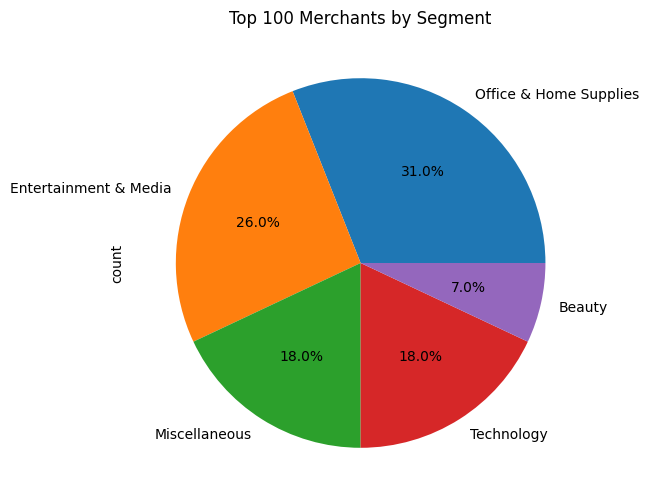

In [31]:
# Creating plots 
import matplotlib.pyplot as plt
import seaborn as sns

# Creating a pie plot for the top 100 merchants
top_100_pd = top_100.toPandas()
plt.figure(figsize=(10, 6))
top_100_pd['segment'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Top 100 Merchants by Segment')
plt.savefig('../plots/top_100_merchants_by_segment.png')
plt.show()

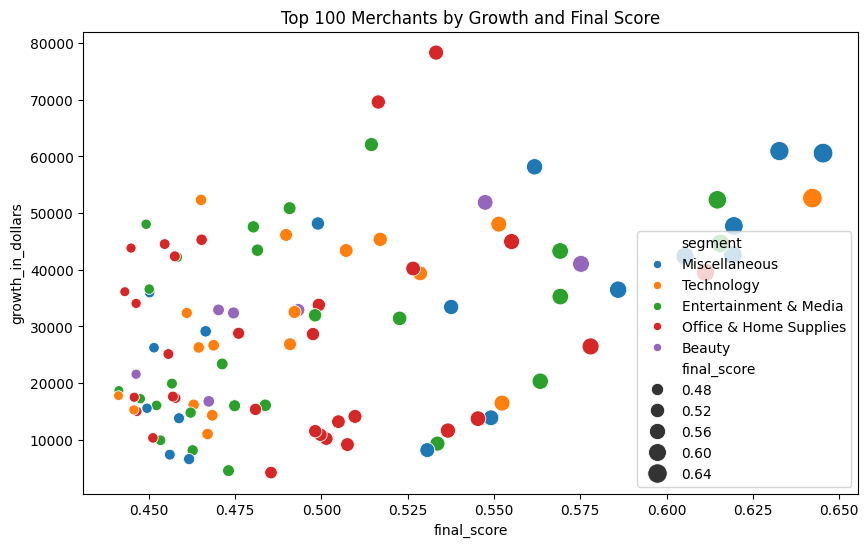

In [28]:
# Doing a weighted scatter plot for the top 100 merchants
plt.figure(figsize=(10, 6))
sns.scatterplot(data=top_100_pd, x='final_score', y='growth_in_dollars', hue='segment', size='final_score', sizes=(50, 200))
plt.title('Top 100 Merchants by Growth and Final Score')
plt.show()